In [61]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
from pylab import rcParams
import requests
import json
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# with open("tingo_api.json", "r") as file:
#     tingo_api = json.load(file)
# api_key = tingo_api['api_key']

In [3]:
# headers = {
#     'Content-Type': 'application/json',
#     'Authorization': f'Token {api_key}'
# }
# url =  "https://api.tiingo.com/tiingo/daily/MSFT/prices?startDate=2017-06-13&endDate=2025-06-13&resampleFreq=1min"


# response = requests.get(url, headers=headers)
# data = response.json()

In [4]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="max", 
    interval="1h",
)

print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-06-15 11:30:00-04:00  345.084991  346.779999  344.679993  346.268890   
2023-06-15 12:30:00-04:00  346.269989  346.619995  344.391388  345.269989   
2023-06-15 13:30:00-04:00  345.290009  347.200012  344.829987  346.804993   
2023-06-15 14:30:00-04:00  346.819305  349.350006  346.750000  348.730011   
2023-06-15 15:30:00-04:00  348.739990  349.839996  347.399994  348.130005   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2023-06-15 11:30:00-04:00        0        0.0           0.0  
2023-06-15 12:30:00-04:00  2754889        0.0           0.0  
2023-06-15 13:30:00-04:00  3567412        0.0           0.0  
2023-06-15 14:30:00-04:00  4584429        0.0           0.0  
2023-06-15 15:30:00-04:00  4413361        0.0           0.0  


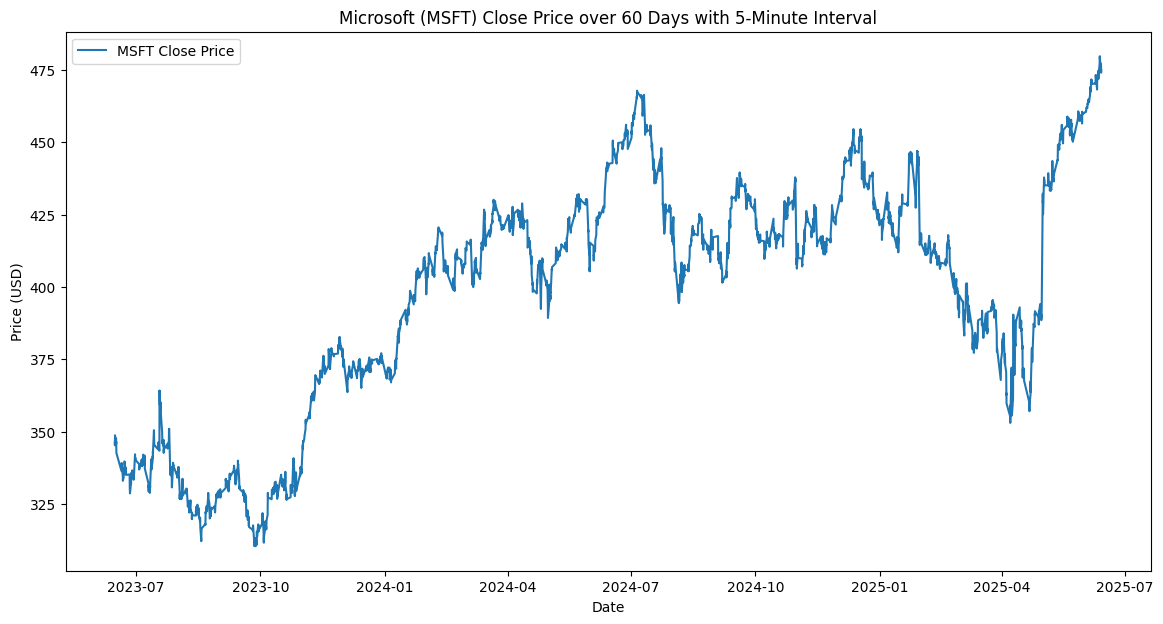

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

# Testing For Stationarity

Results of dickey fuller test
Test Statistics                  -1.365442
p-value                           0.598727
No. of lags used                  0.000000
Number of observations used    3484.000000
critical value (1%)              -3.432228
critical value (5%)              -2.862370
critical value (10%)             -2.567212
dtype: float64


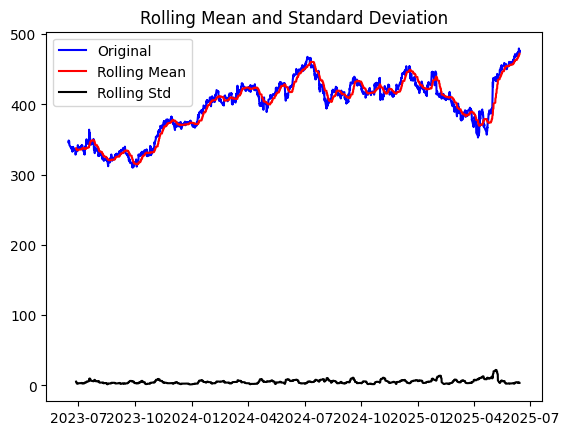

In [6]:

def test_stationarity(timeseries):
   
    rolmean = timeseries.rolling(50).mean()
    rolstd = timeseries.rolling(50).std()
 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(msft_df['Close'])

Interpretation: 
* Null Hypothesis: The time series is non-stationary.
* Alternative Hypothesis: The time series is stationary.

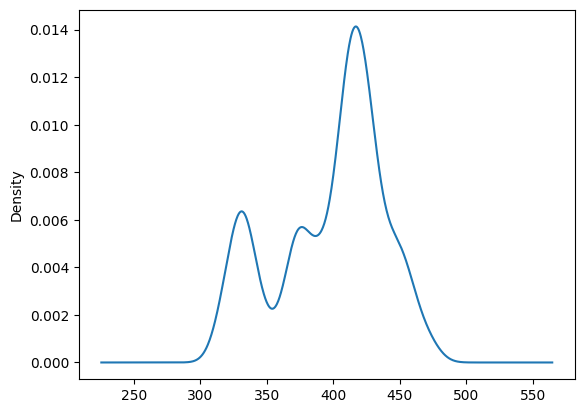

In [7]:
msft_df['Close'].plot(kind='kde');

<Figure size 640x480 with 0 Axes>

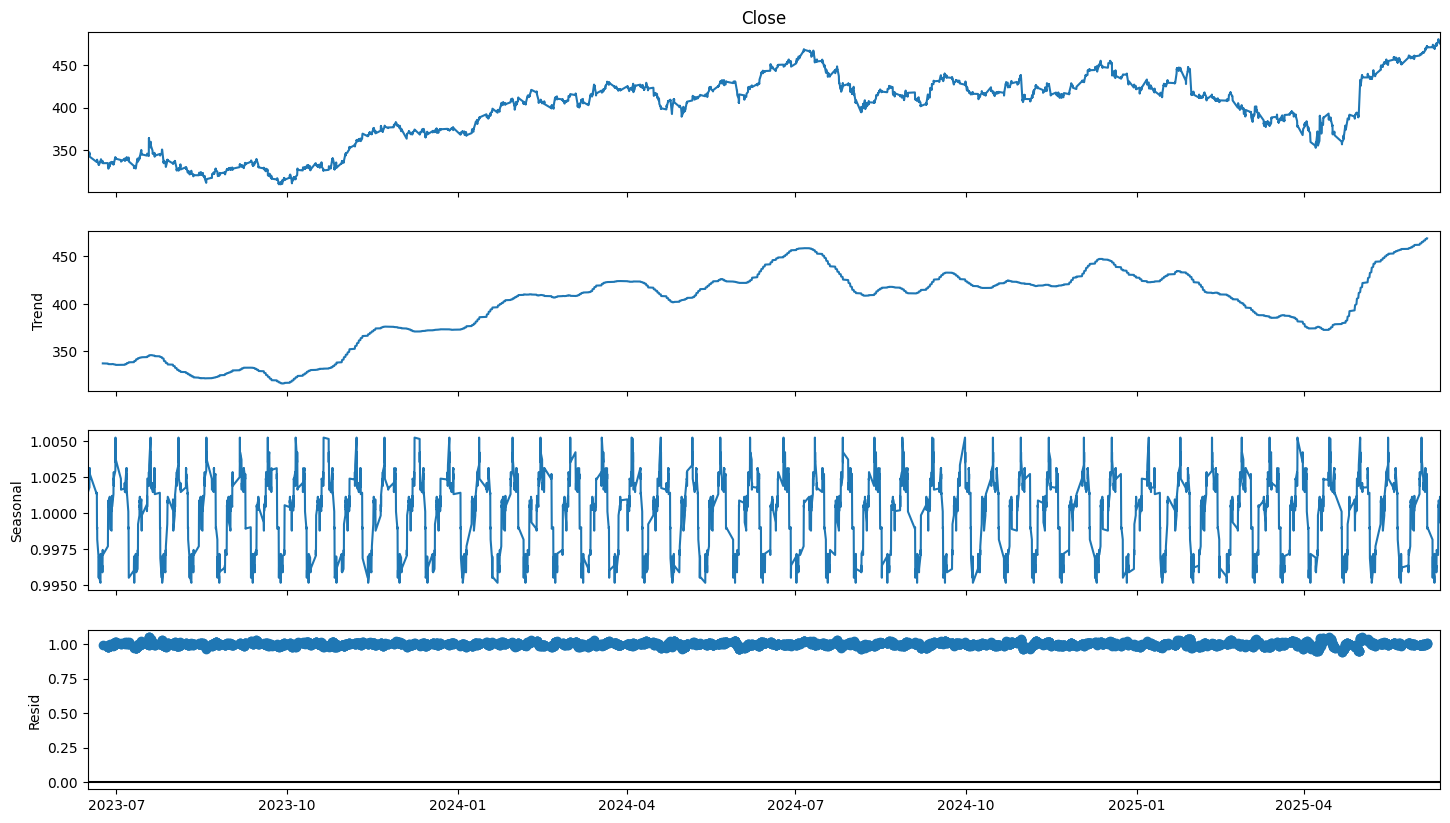

In [8]:
result = seasonal_decompose(msft_df['Close'], model='multiplicative', period = 78)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

# Reducing Trend

C:\Users\billy\AppData\Local\Temp\ipykernel_10660\3003609869.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


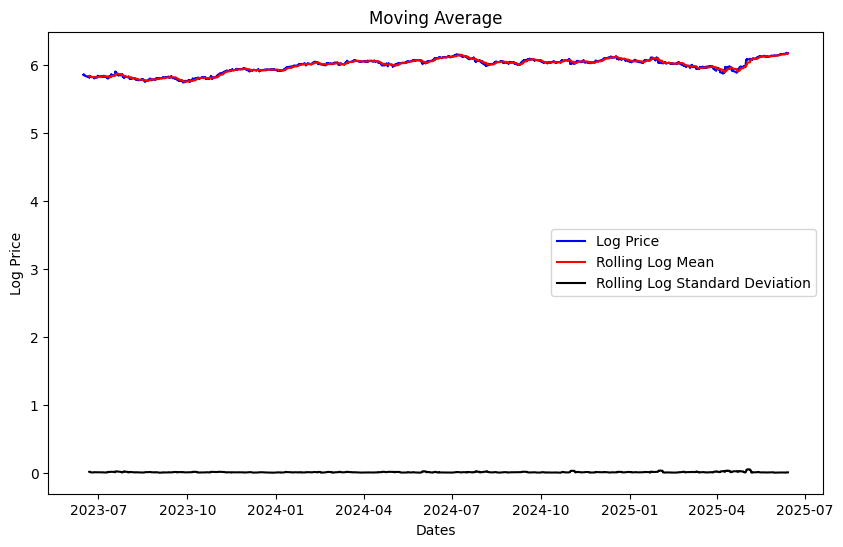

In [9]:
rcParams['figure.figsize'] = 10, 6
msft_df['Log_Close'] = np.log(msft_df['Close'])
msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(24).mean()
msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(24).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(msft_df['Log_Close'], color='blue', label = 'Log Price')
plt.plot(msft_df['Rolling_Log_Avg'], color="red", label = "Rolling Log Mean")
plt.plot(msft_df['Rolling_Log_Std'], color = "black", label = "Rolling Log Standard Deviation")
plt.xlabel('Dates')
plt.ylabel('Log Price')
plt.legend()
plt.show()

# Train/Test 

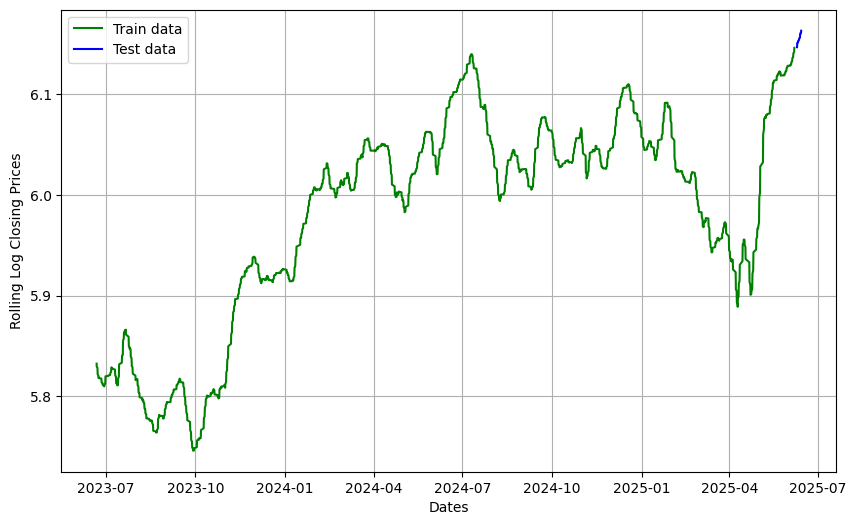

In [10]:
msft_df.dropna(inplace=True)
train_size = int(len(msft_df) * 0.99)
train_data, test_data =  msft_df['Rolling_Log_Avg'].iloc[:train_size], msft_df['Rolling_Log_Avg'].iloc[train_size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Rolling Log Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

# HyperParameter Tuning: P, D, Q

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37206.429, Time=0.46 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-45076.404, Time=0.86 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-39978.559, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37182.879, Time=0.14 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45074.695, Time=0.97 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45074.719, Time=1.24 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-37200.542, Time=1.52 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45077.830, Time=0.35 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45076.109, Time=1.00 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45076.122, Time=0.25 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-39987.577, Time=0.23 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-37177.018, Time=0.88 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.500 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3427
Model:               SARIMAX(1, 1, 0)   Log Likelihood               22540.915
Date:                Sat, 14 Jun 2025   AIC                         -45077.830
Time:                        10:43:07   BIC                         -45065.552
Sample:                             0   HQIC                        -45073.444
                               - 3427                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9486      0.004    224.301      0.000       0.94

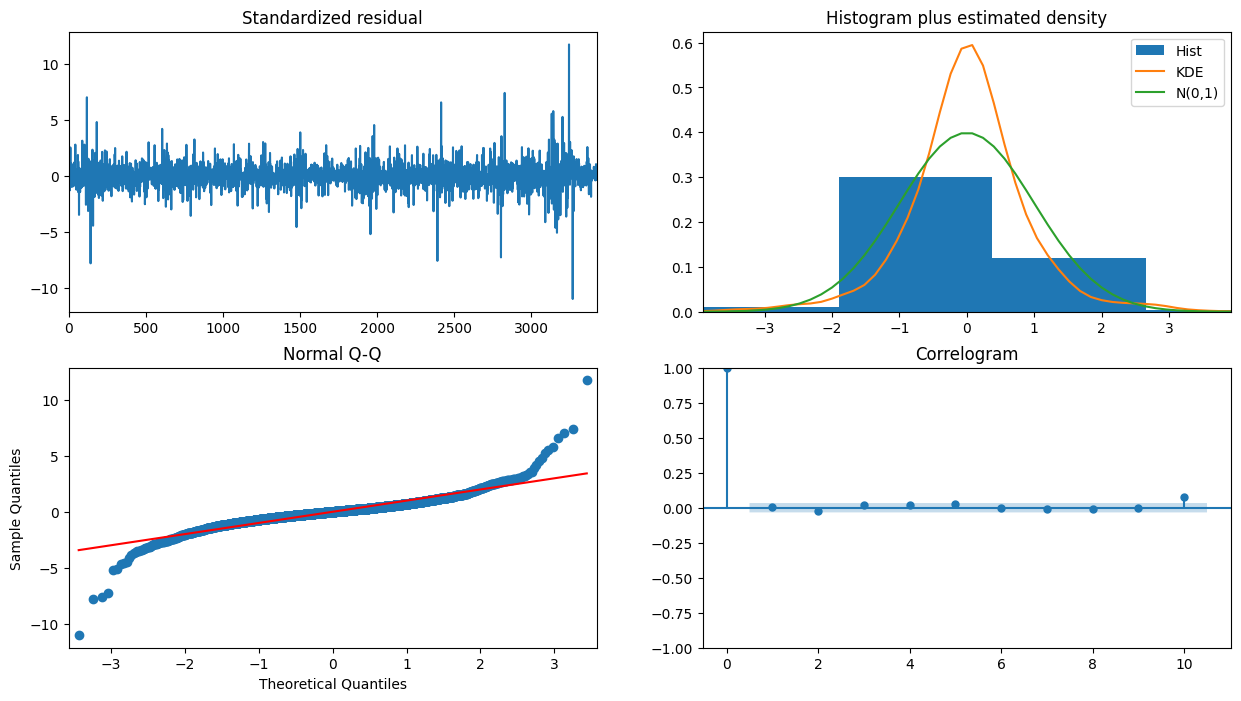

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

## Test residual autocorrelation

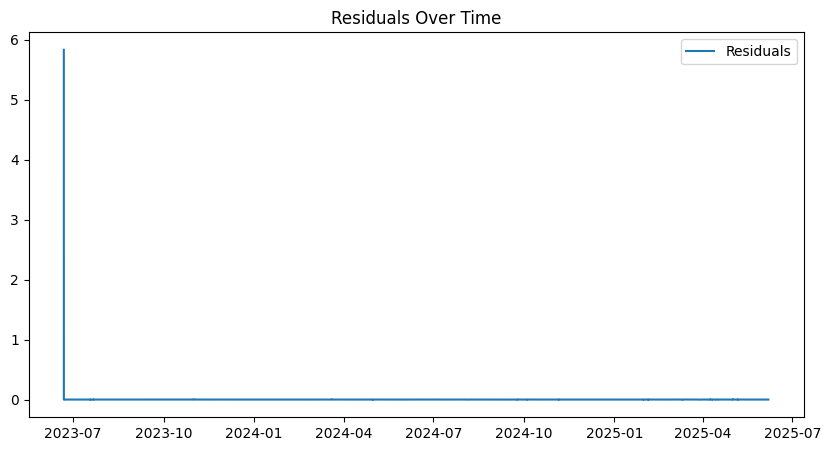

In [12]:
residuals = model_autoARIMA.resid()
plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.legend()
plt.title("Residuals Over Time")
plt.show()

Ljung-Box Test Hypothesis test
* Null Hypothesis: - The residuals are independently distributed (i.e., no autocorrelation).
* Alternative: The residuals are not independent (i.e., they're autocorrelated)

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[1], return_df=True)
print(ljung_box_results)

    lb_stat  lb_pvalue
1  0.000223   0.988085


# Fit Model with Optimal Parameters

In [20]:
model_autoARIMA.order

(1, 1, 0)

In [86]:
num_splits = int(0.89 * len(msft_df))
tscv = TimeSeriesSplit(n_splits=100)
best_p, best_d, bestq = model_autoARIMA.order

actual_values = []
predicted_values = []
simple_values = []


for train_idx, test_idx in tscv.split(msft_df):
    train, test = msft_df['Rolling_Log_Avg'].iloc[train_idx], msft_df['Rolling_Log_Avg'].iloc[test_idx]
    arima = ARIMA(train, order =(best_p, best_d, bestq))
    arima_fit = arima.fit()
    forecast = arima_fit.forecast(steps=1)
    #mse = mean_squared_error(], forecast.values)
    actual_values.append(test[0])
    predicted_values.append(forecast.values[0])
    simple_values.append(train[-1])
    #results.append({"Train Size": len(train), "Test Size": len(test), "MSE": mse})
print("Actual Vs Predited:", mean_squared_error(actual_values, predicted_values))
print("Actual Vs Simple:", mean_squared_error(actual_values, simple_values))
#results_df = pd.DataFrame(results)
#print(results_df)

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

Actual Vs Predited: 9.267573075919506e-08
Actual Vs Simple: 1.283536033928409e-06


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\billy\AppData\Local\Temp\ipykernel_10660\1557785152.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_values.append(test[0])
C:\Users\billy\AppData\Local\Temp\ipykernel_10660\1557785152.py:18: FutureWarning: Series.__getitem__ treating keys a

In [ ]:
tscv.split(msft_df)

In [ ]:

arima_fitted = ARIMA(train_data, order=(best_p,best_d,bestq)).fit()
print(arima_fitted.summary())

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        Rolling_Log_Avg   No. Observations:                 3427
Model:                 ARIMA(1, 1, 0)   Log Likelihood               22540.915
Date:                Sat, 14 Jun 2025   AIC                         -45077.830
Time:                        10:43:08   BIC                         -45065.552
Sample:                             0   HQIC                        -45073.444
                               - 3427                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9486      0.004    224.301      0.000       0.940       0.957
sigma2      1.128e-07   9.74e-10    115.798      0.000    1.11e-07    1.15e-07
Ljung-Box (L1) (Q):                   0.24   Jarque-

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


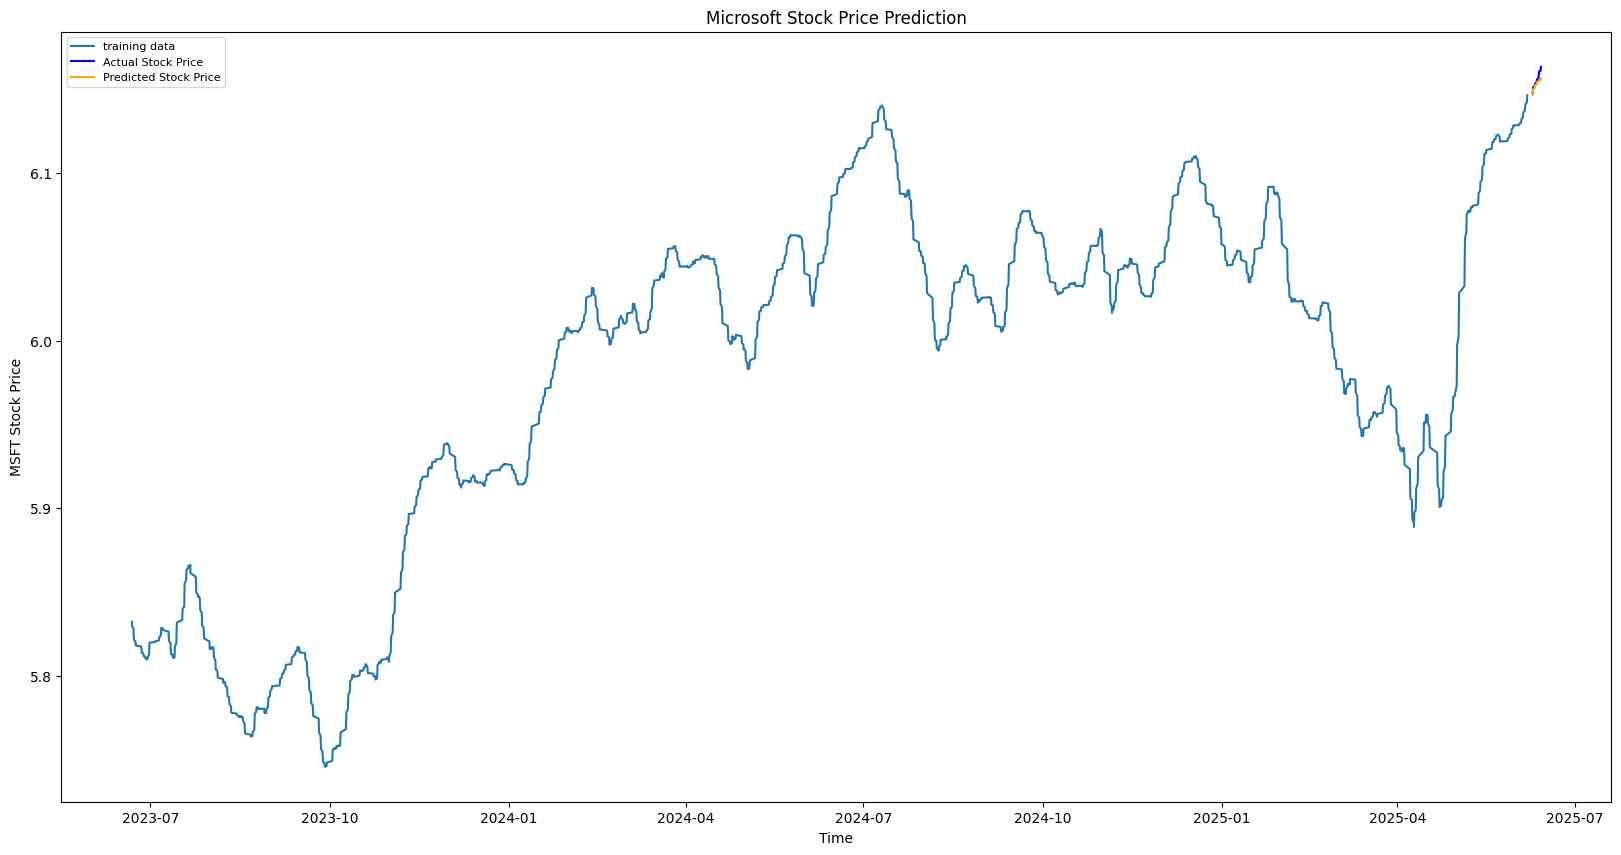

In [ ]:
forecast = arima_fitted.forecast(steps=len(test_data))
plt.figure(figsize=(20,10))
plt.plot(train_data.index, train_data,  label='training data')
plt.plot(test_data.index, test_data, color = 'blue', label='Actual Stock Price')
plt.plot(test_data.index, forecast, color = 'orange',label='Predicted Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
#plt.savefig("3mo.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
print("Mean Squared Error:", mean_squared_error(test_data, forecast))
print("Root Mean Square Error:", np.sqrt(mean_squared_error(test_data, forecast)))
print("Mean Absolute Error:", mean_absolute_error(test_data, forecast))
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(test_data, forecast))

Mean Squared Error: 1.1164631678491847e-05
Root Mean Square Error: 0.0033413517741315187
Mean Absolute Error: 0.0025789252104809536
Mean Absolute Percentage Error: 0.00041871333789362793


In [55]:
timestamps = test_data.index[-4:]  
actual_values = np.exp(test_data.iloc[-4:])
predicted_values = np.exp(forecast[-4:])

df_results = pd.DataFrame({
    'Timestamp': timestamps,
    'Actual Value': actual_values.values, 
    'Predicted Value': predicted_values
})

print(df_results)


                     Timestamp  Actual Value  Predicted Value
3458 2025-06-13 12:30:00-04:00    474.422605       471.550938
3459 2025-06-13 13:30:00-04:00    474.632255       471.603619
3460 2025-06-13 14:30:00-04:00    474.829414       471.653599
3461 2025-06-13 15:30:00-04:00    475.058291       471.701016


In [ ]:
# previous_values = np.exp(test_data[-2:].values.flatten())
# forecast = model_autoARIMA.predict(n_periods=1, X=test_data[-2:].values.reshape(1, -1)).iloc[0]
# forecast_price = np.exp(forecast)

# data = {
#     "datetime": [test_data.index[-2], test_data.index[-1], "Forecasted Next Hour"],
#     "close_price": [previous_values[0], previous_values[1], forecast_price]
# }

# df_forecast = pd.DataFrame(data)
# df_forecast